In [1]:
import os
import sys
root_dir = os.path.abspath('../')
sys.path.append(root_dir)

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Stunning palette: Viridis or Plasma ---
palette = sns.color_palette("viridis", 8)

sns.set_theme(
    style="whitegrid",
    font="sans-serif",
    rc={
        "font.size": 13,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "axes.labelweight": "semibold",
        "axes.edgecolor": "#2F2F2F",
        "axes.linewidth": 0.8,
        "grid.color": "#CCCCCC",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "figure.facecolor": "#FAFAFA",
        "axes.facecolor": "#FFFFFF",
        "axes.prop_cycle": plt.cycler("color", palette),
    }
)

In [2]:
# Engineered data
lavar_data1 = pd.read_parquet(
    os.path.join(root_dir, "example/lavar_daily1.parquet")
)  # demographics, diagnosis code

lavar_data2 = pd.read_parquet(
    os.path.join(root_dir, "example/lavar_daily2.parquet")
)  # demographics, ATC code

# Resample, daily-wise
full_range = pd.date_range(lavar_data1.index.min(), lavar_data1.index.max(), freq='D')
lavar_data1 = lavar_data1.reindex(full_range)
lavar_data2 = lavar_data2.reindex(full_range)

lavar_data1 = lavar_data1.fillna(0)
lavar_data2 = lavar_data2.fillna(0)

common = [i for i in lavar_data1.columns if i in lavar_data2.columns]
col1 = [i for i in lavar_data1.columns if i not in common]
col2 = [i for i in lavar_data2.columns if i not in common]

non_supply_df = lavar_data1[common + col1]
non_supply_cols = common + col1
supply_df = lavar_data2[col2]
supply_cols = col2

X = torch.tensor(non_supply_df.values, dtype=torch.float32)  # (T, Dx)
y = torch.tensor(supply_df.values, dtype=torch.float32)      # (T, Dy)

# (torch.Size([2556, 40]), torch.Size([2556, 36]))
# T = 2556, Dx = 40, Dy = 36
X.shape, y.shape  

(torch.Size([2556, 40]), torch.Size([2556, 36]))

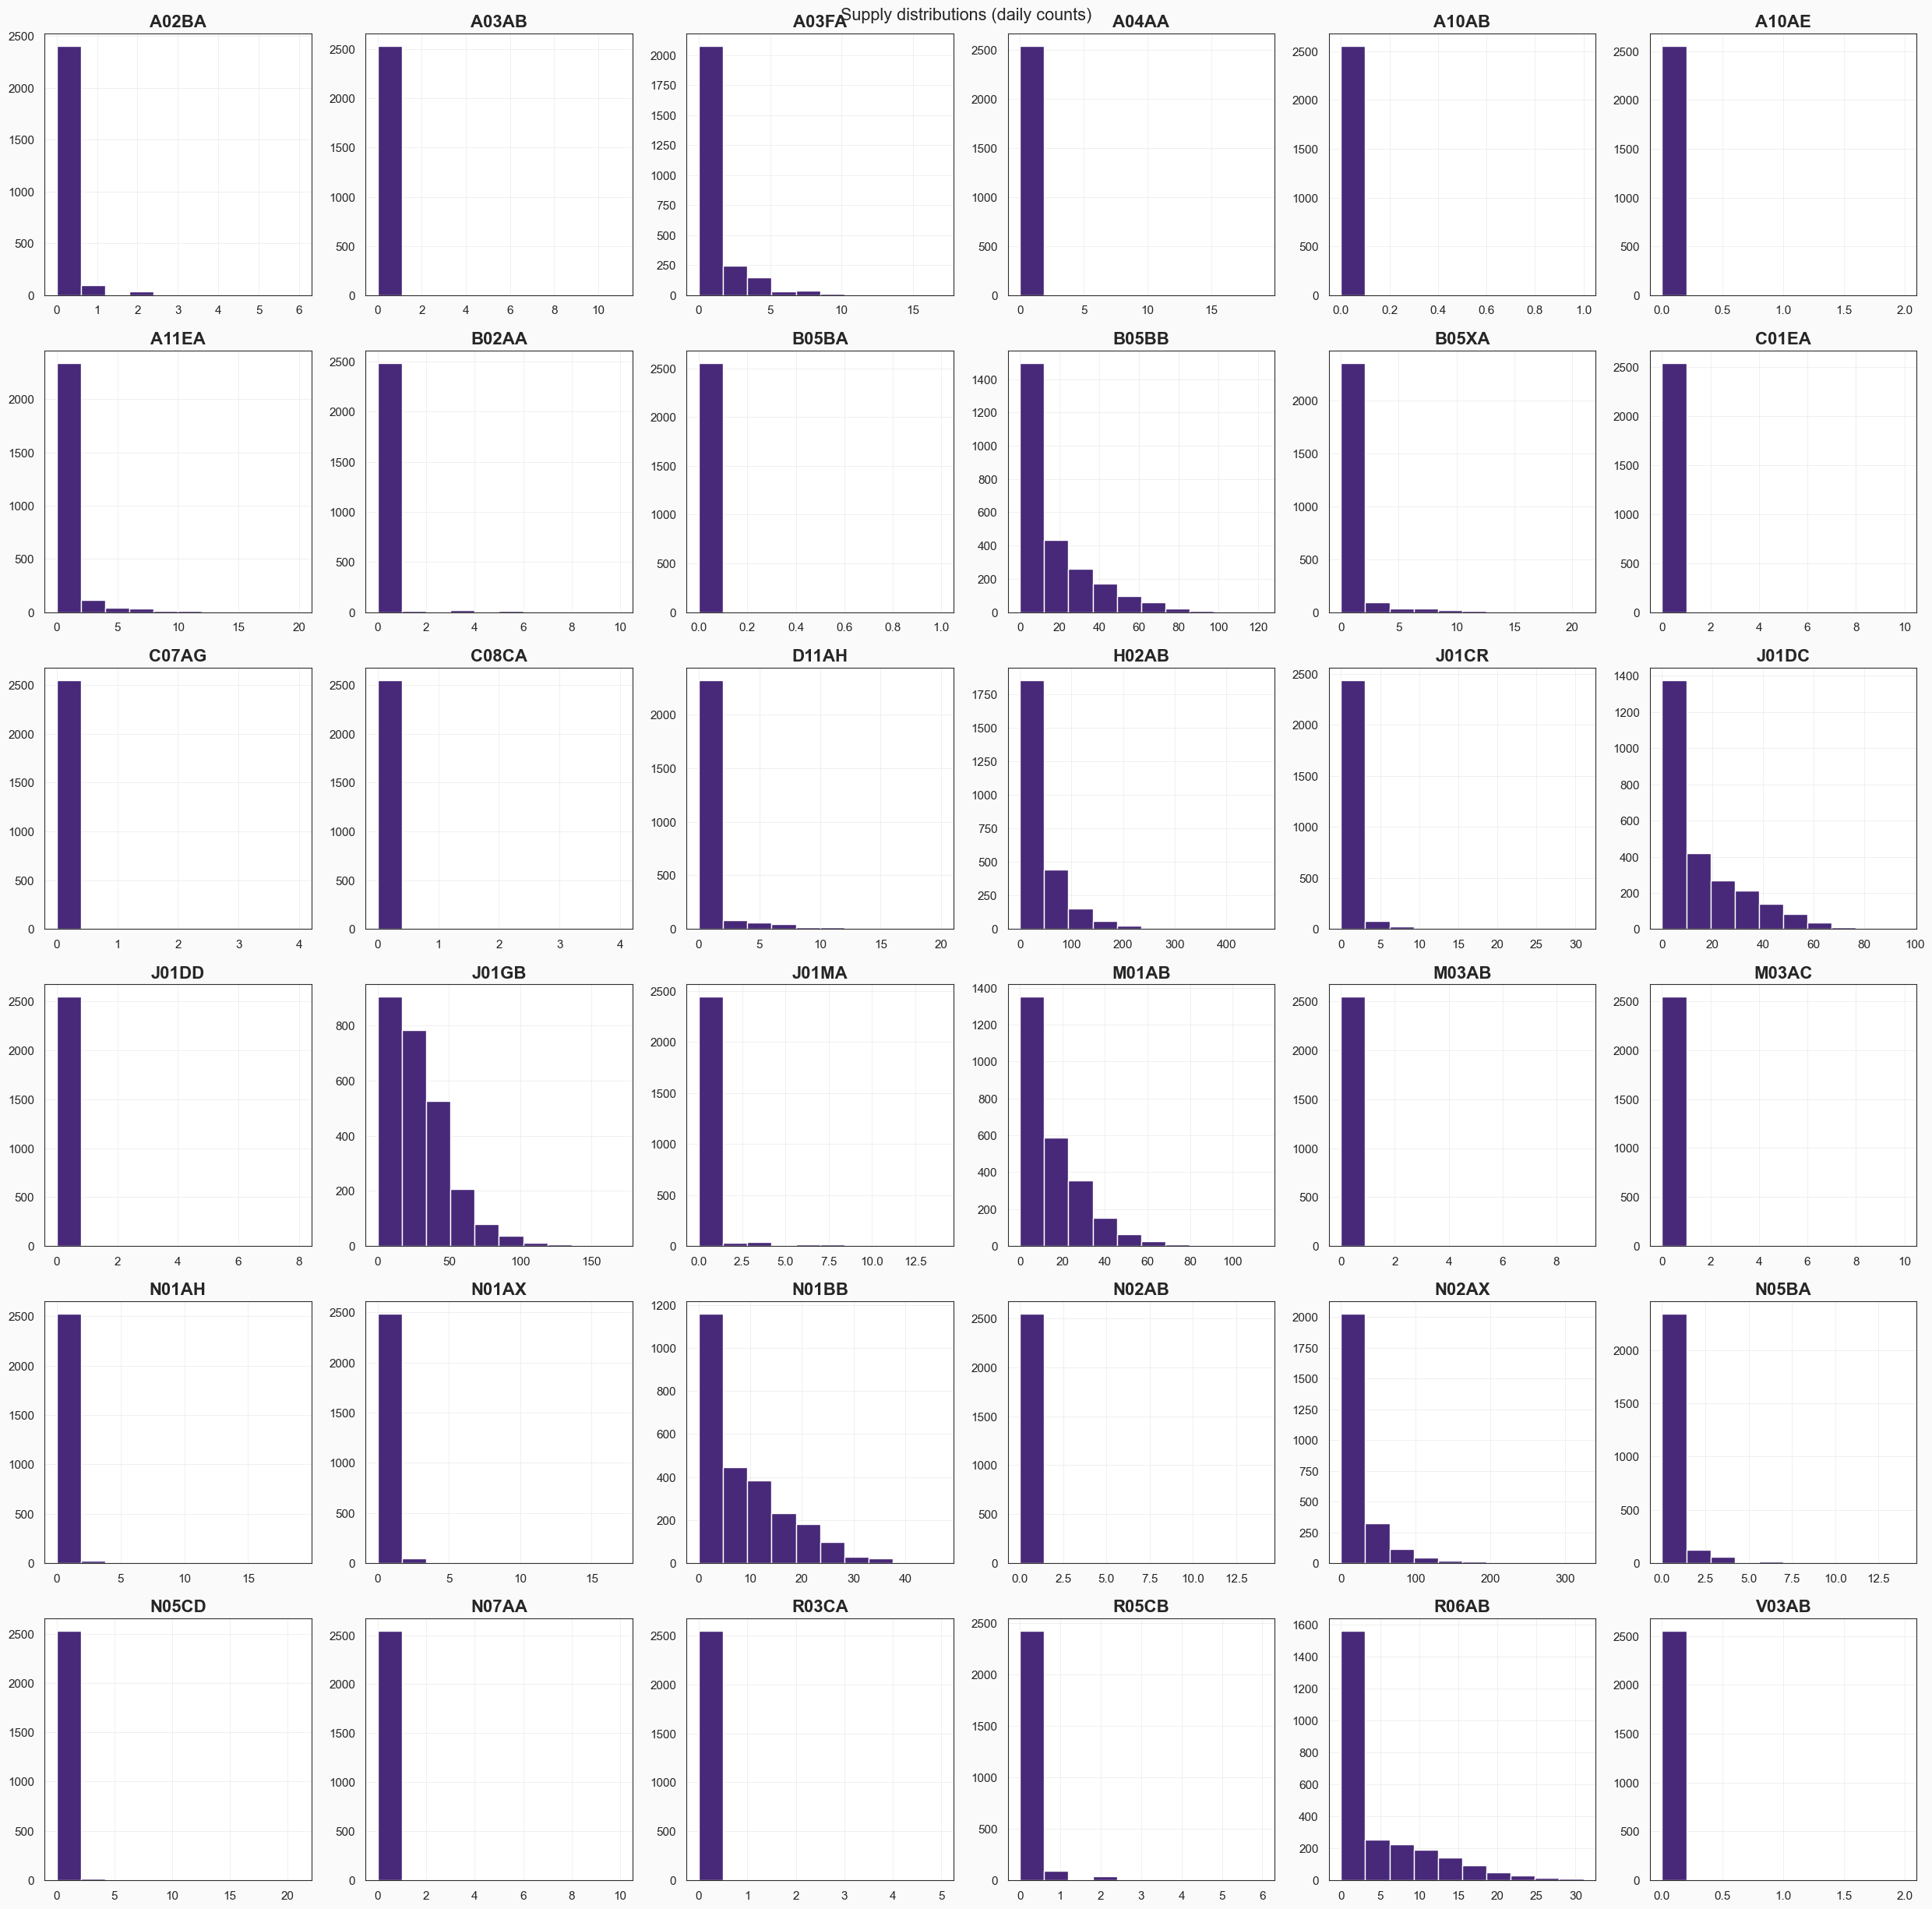

Global buckets (full history): dense=4, sparse=20, ultra_rare=12


In [7]:
# --- Supply distribution overview (full dataset) ---
# Note: for training-time bucket assignment we recompute on y_train_raw inside each fold (no leakage).

supply_df.hist(figsize=(25, 25))
plt.suptitle("Supply distributions (daily counts)")
plt.tight_layout()
plt.show()

# Quick global (full-history) bucket counts for sanity-check (NONZERO-rate based)
nonzero_rate_all = (y > 0).float().mean(dim=0)
dense_thr = 0.70
ultra_thr = 0.005

dense_all = int((nonzero_rate_all >= dense_thr).sum().item())
ultra_all = int((nonzero_rate_all <= ultra_thr).sum().item())
sparse_all = int((~((nonzero_rate_all >= dense_thr) | (nonzero_rate_all <= ultra_thr))).sum().item())
print(f"Global buckets (full history): dense={dense_all}, sparse={sparse_all}, ultra_rare={ultra_all}")


In [11]:
supply_df.value_counts()

A02BA  A03AB  A03FA  A04AA  A10AB  A10AE  A11EA  B02AA  B05BA  B05BB  B05XA  C01EA  C07AG  C08CA  D11AH  H02AB  J01CR  J01DC  J01DD  J01GB  J01MA  M01AB  M03AB  M03AC  N01AH  N01AX  N01BB  N02AB  N02AX  N05BA  N05CD  N07AA  R03CA  R05CB  R06AB  V03AB
0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0      457
                                                                                                                                     8.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0        2
                                                                                                                       2.0    0.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.